K-Means Clustering on Credit Card Dataset - Clustering

Importing the required dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Creating Functions
1-LoadData
2-CleanFun
3-KYFS
4-FTRsclt
5-PCAViz
6-ClusterFun
7-VizFun

1. LoadData

In [2]:
import chardet
import pandas as pd

def import_dataset(Loc):
    # Read the raw data to detect encoding
    rawdata = open(Loc, 'rb').read()
    result = chardet.detect(rawdata)

    # Read the CSV file using the detected encoding
    data = pd.read_csv(Loc, encoding=result['encoding'])

    return data



2. CleanFun

In [3]:

def list_columns_with_missing_values(df):
    result=df.isnull().sum(0)
    return result


def drop_null(df): #This function will clean the dataset by dropping null values.
    df.dropna(inplace=True)
    return(df)

def fill_null_mean(df):

    df_float = df.select_dtypes(include='float64').columns.tolist()
    # Make a copy of float columns
    X = df[df_float].copy()

    # Calculate means of each column
    means = X.mean()

    # Fill missing values with mean values
    X.fillna(value=means, inplace=True)

    # Assign the filled float columns back to the original DataFrame
    df[df_float] = X

    return df


# Usage:
# df = fill_null_mean(df)


def fill_null_median(df): #This function will clean the dataset by dropping null values.
    median=df.median()
    df.fillna(value=median, inplace=True)  # Fill missing values with mean values
    return(df)


def fill_null_knn(df):

    columns_with_missing_values = df.columns[df.isnull().any()].tolist()
    # extract the data from the selected columns
    X = df[columns_with_missing_values].values

    # create a KNN imputer object with k
    imputer = KNNImputer(n_neighbors=2)

    # impute the missing values using KNN imputation
    X_imputed = imputer.fit_transform(X)

    # replace the original columns with the imputed columns
    df[columns_with_missing_values] = X_imputed

    return(df)

def fill_null_knn(df):
# Assuming df is your dataframe
    imputer = KNNImputer()
    imputed_data = imputer.fit_transform(df)

    # Replace original dataframe with imputed data
    df = pd.DataFrame(imputed_data, columns=df.columns)
    return df
# Use below function after converting categorical variable to dummy variable.

def filter_fill_replace(df, threshold, fill_technique='mean'):
    # Step 1: Filter DataFrame based on number of missing values
    columns_with_missing_values = df.columns[df.isnull().any()]
    filtered_df = df[columns_with_missing_values[df[columns_with_missing_values].isnull().sum() > threshold]]

    # Step 2: Fill missing values using specified technique
    for column in filtered_df.columns:

        if fill_technique == 'mean':
            fill_value = filtered_df[column].mean()
        elif fill_technique == 'median':
            fill_value = filtered_df[column].median()
        elif fill_technique == 'mode':
            fill_value = filtered_df[column].mode().iloc[0]  # Use mode for categorical data
        elif fill_technique == 'knn':
            filled_df = fill_null_knn(filtered_df)
            df[filtered_df.columns] = filled_df
            return df
        else:
            raise ValueError("Invalid fill technique. Supported techniques: 'mean', 'median', 'mode', 'knn'")

        filtered_df[column].fillna(fill_value, inplace=True)

    # Step 3: Replace filled columns back into the original DataFrame
    df[filtered_df.columns] = filtered_df

    return df

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

def impute_missing_mice(df, max_iter=10, random_state=None):

    # Initialize MICE imputer
    imputer = IterativeImputer(max_iter=max_iter, random_state=random_state)

    # Fit and transform the data
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    return imputed_df


def dealing_with_duplicates(df): #This function will clean the dataset.
    print("Number of duplicate rows in your data set:",df.duplicated().sum())
    print("All the duplicate rows have been deleted from data set")

    df.drop_duplicates(inplace=True)
    return(df)




3. KYFS

In [4]:
def description_dataset(df):

    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] / len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc['min'] = df.min()
    desc['max'] = df.max()
    return desc

4. FTRsclt

In [5]:
def eda(df, hist_color='MAROON', boxplot_color='MAROON'):
    # Separating numerical and categorical features
    numeric_features = df.select_dtypes(include=['float64','int64'])
    categorical_features = df.select_dtypes(include=['object', 'int64'])

    # Summary statistics
    summary_stats = numeric_features.describe().style.set_properties(**{'color': 'maroon', 'text-align': 'center', 'font-weight': 'bold'})
    print("\n\033[1m\033[91mSummary Statistics:\033[0m")
    display(summary_stats)


    num_cols = len(numeric_features.columns)
    num_rows = (num_cols - 1) // 3 + 1  # Calculate number of rows needed

    # Histograms and Box plots
    fig, axes = plt.subplots(nrows=num_rows*2, ncols=3, figsize=(16, 5*num_rows))

    for i, column in enumerate(numeric_features.columns):
        row = i // 3
        col = i % 3

        sns.histplot(df[column], bins=20, kde=True, color=hist_color, ax=axes[row*2, col])
        axes[row*2, col].set_title(f'Histogram of {column}')
        axes[row*2, col].set_xlabel(column)
        axes[row*2, col].set_ylabel('Frequency')

        sns.boxplot(data=df, y=column, color=boxplot_color, ax=axes[row*2+1, col])
        axes[row*2+1, col].set_title(f'Boxplot of {column}')
        axes[row*2+1, col].set_ylabel(column)

    plt.tight_layout()
    plt.show()

    # Correlation matrix
    # Calculate correlation matrix
    correlation_matrix = numeric_features.corr()

    # Correlation matrix
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=1)
    plt.title('Correlation Heatmap of 30 Variables')
    plt.xlabel('Variables')
    plt.ylabel('Variables')
    plt.show()

5. PCAViz

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

def calculate_centroids(data, n_clusters=3):
    """
    Calculate the centroids of clusters after applying K-means clustering.

    Parameters:
    - data: The dataset to cluster (2D numpy array or pandas DataFrame).
    - n_clusters: The number of clusters to form (default is 3).

    Returns:
    - centroids: The coordinates of the cluster centers.
    - labels: The labels assigned to each data point.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    return centroids, labels

def PCA_Viz_with_KMeans(data, n_clusters=3):
    """
    Perform PCA, apply K-means, and visualize clusters with centroids.

    Parameters:
    - data: The dataset to reduce and cluster.
    - n_clusters: The number of clusters for K-means (default is 3).

    Returns:
    - pca_data: PCA reduced data.
    - labels: Cluster labels for the data.
    - centroids: Coordinates of the centroids in PCA space.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)
    
    centroids, labels = calculate_centroids(pca_data, n_clusters)
    
    # Plot PCA results with centroids
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, s=50, cmap='viridis', alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title('PCA Visualization with K-means Clustering')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.colorbar(scatter, label='Cluster')
    plt.show()
    
    # Print centroids
    print("PCA Centroids:\n", centroids)
    
    return pca_data, labels, centroids

def tSNE_Viz_with_KMeans(data, n_clusters=3, perplexity=30, n_iter=300):
    """
    Perform t-SNE, apply K-means, and visualize clusters with centroids.

    Parameters:
    - data: The dataset to reduce and cluster.
    - n_clusters: The number of clusters for K-means (default is 3).
    - perplexity: Perplexity parameter for t-SNE.
    - n_iter: Number of iterations for t-SNE.

    Returns:
    - tsne_data: t-SNE reduced data.
    - labels: Cluster labels for the data.
    - centroids: Coordinates of the centroids in t-SNE space.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_data = tsne.fit_transform(scaled_data)
    
    centroids, labels = calculate_centroids(tsne_data, n_clusters)
    
    # Plot t-SNE results with centroids
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, s=50, cmap='viridis', alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title('t-SNE Visualization with K-means Clustering')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.colorbar(scatter, label='Cluster')
    plt.show()
    
    # Print centroids
    print("t-SNE Centroids:\n", centroids)
    
    return tsne_data, labels, centroids


In [111]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def calculate_silhouette_scores(data, cluster_nums):
    """
    Calculate and plot Silhouette Scores for different numbers of clusters.
    
    Parameters:
    - data: pd.DataFrame or np.ndarray, the input features for clustering
    - cluster_nums: list of int or single int, the number of clusters to evaluate
    """
    # Ensure cluster_nums is a list
    if isinstance(cluster_nums, int):
        cluster_nums = [cluster_nums]
    elif not isinstance(cluster_nums, list):
        raise TypeError("cluster_nums should be a list of integers or a single integer")

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Prepare list to store silhouette scores
    scores = []
    
    # Calculate Silhouette Score for each number of clusters
    for cluster_num in cluster_nums:
        kmeans = KMeans(n_clusters=cluster_num, random_state=0)
        kmeans.fit(scaled_data)
        clusters = kmeans.predict(scaled_data)
        silhouette = silhouette_score(scaled_data, clusters)
        scores.append(silhouette)
    
    # Print the results
    print("Cluster Numbers:", cluster_nums)
    print("Silhouette Scores:", scores)
    
    # Plot Silhouette Scores
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_nums, scores, color='b', alpha=0.7)
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(cluster_nums)  # Ensure all cluster numbers are shown
    plt.grid(axis='y')
    plt.show()

In [117]:
import numpy as np

def polar_plot(data, labels, centroids, title='Polar Plot of Clusters'):
    """
    Create a polar plot to visualize the clusters and their centroids.

    Parameters:
    - data: The dataset with cluster labels.
    - labels: Cluster labels for the data points.
    - centroids: Coordinates of the centroids.
    - title: Title of the plot.
    """
    # Convert data to polar coordinates
    r = np.linalg.norm(data, axis=1)
    theta = np.arctan2(data[:, 1], data[:, 0])
    
    plt.figure(figsize=(10, 8))
    plt.subplot(projection='polar')
    
    scatter = plt.scatter(theta, r, c=labels, s=50, cmap='viridis', alpha=0.6, edgecolors='w')
    plt.scatter(np.arctan2(centroids[:, 1], centroids[:, 0]), np.linalg.norm(centroids, axis=1), c='red', s=200, marker='X', label='Centroids')
    
    plt.title(title)
    plt.legend()
    plt.colorbar(scatter, label='Cluster')
    plt.show()

In [118]:
def bar_plot_clusters(labels, title='Cluster Distribution'):
    """
    Create a bar plot to show the distribution of points across clusters.

    Parameters:
    - labels: Cluster labels for the data points.
    - title: Title of the plot.
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='b', alpha=0.7)
    plt.title(title)
    plt.xlabel('Cluster Number')
    plt.ylabel('Number of Points')
    plt.xticks(unique_labels)
    plt.grid(axis='y')
    plt.show()

Master Function

In [81]:
data=import_dataset(r'Credit Card Dataset for Clustering.csv')

In [82]:
data.shape

(8950, 18)

In [83]:
data=dealing_with_duplicates(data)

Number of duplicate rows in your data set: 0
All the duplicate rows have been deleted from data set


In [84]:
data=fill_null_mean(data)

In [85]:
description_dataset(data)

type  count  nunique     %unique  null  \
CUST_ID                            object   8950     8950  100.000000     0   
BALANCE                           float64   8950     8871   99.117318     0   
BALANCE_FREQUENCY                 float64   8950       43    0.480447     0   
PURCHASES                         float64   8950     6203   69.307263     0   
ONEOFF_PURCHASES                  float64   8950     4014   44.849162     0   
INSTALLMENTS_PURCHASES            float64   8950     4452   49.743017     0   
CASH_ADVANCE                      float64   8950     4323   48.301676     0   
PURCHASES_FREQUENCY               float64   8950       47    0.525140     0   
ONEOFF_PURCHASES_FREQUENCY        float64   8950       47    0.525140     0   
PURCHASES_INSTALLMENTS_FREQUENCY  float64   8950       47    0.525140     0   
CASH_ADVANCE_FREQUENCY            float64   8950       54    0.603352     0   
CASH_ADVANCE_TRX                    int64   8950       65    0.726257     0   
PURCHASES_TRX                       int64   8950      173    1.932961     0   
CREDIT_LIMIT                      float64   8950      206    2.301676     0   
PAYMENTS                          float64   8950     8711   97.329609     0   
MINIMUM_PAYMENTS                  float64   8950     8637   96.502793     0   
PRC_FULL_PAYMENT                  float64   8950       47    0.525140     0   
TENURE                              int64   8950        7    0.078212     0   

                                  %null       min          max  
CUST_ID                             0.0    C10001       C19190  
BALANCE                             0.0       0.0  19043.13856  
BALANCE_FREQUENCY                   0.0       0.0          1.0  
PURCHASES                           0.0       0.0     49039.57  
ONEOFF_PURCHASES                    0.0       0.0     40761.25  
INSTALLMENTS_PURCHASES              0.0       0.0      22500.0  
CASH_ADVANCE                        0.0       0.0  47137.21176  
PURCHASES_FREQUENCY                 0.0       0.0          1.0  
ONEOFF_PURCHASES_FREQUENCY          0.0       0.0          1.0  
PURCHASES_INSTALLMENTS_FREQUENCY    0.0       0.0          1.0  
CASH_ADVANCE_FREQUENCY              0.0       0.0          1.5  
CASH_ADVANCE_TRX                    0.0         0          123  
PURCHASES_TRX                       0.0         0          358  
CREDIT_LIMIT                        0.0      50.0      30000.0  
PAYMENTS                            0.0       0.0  50721.48336  
MINIMUM_PAYMENTS                    0.0  0.019163  76406.20752  
PRC_FULL_PAYMENT                    0.0       0.0          1.0  
TENURE                              0.0         6           12


Summary Statistics:


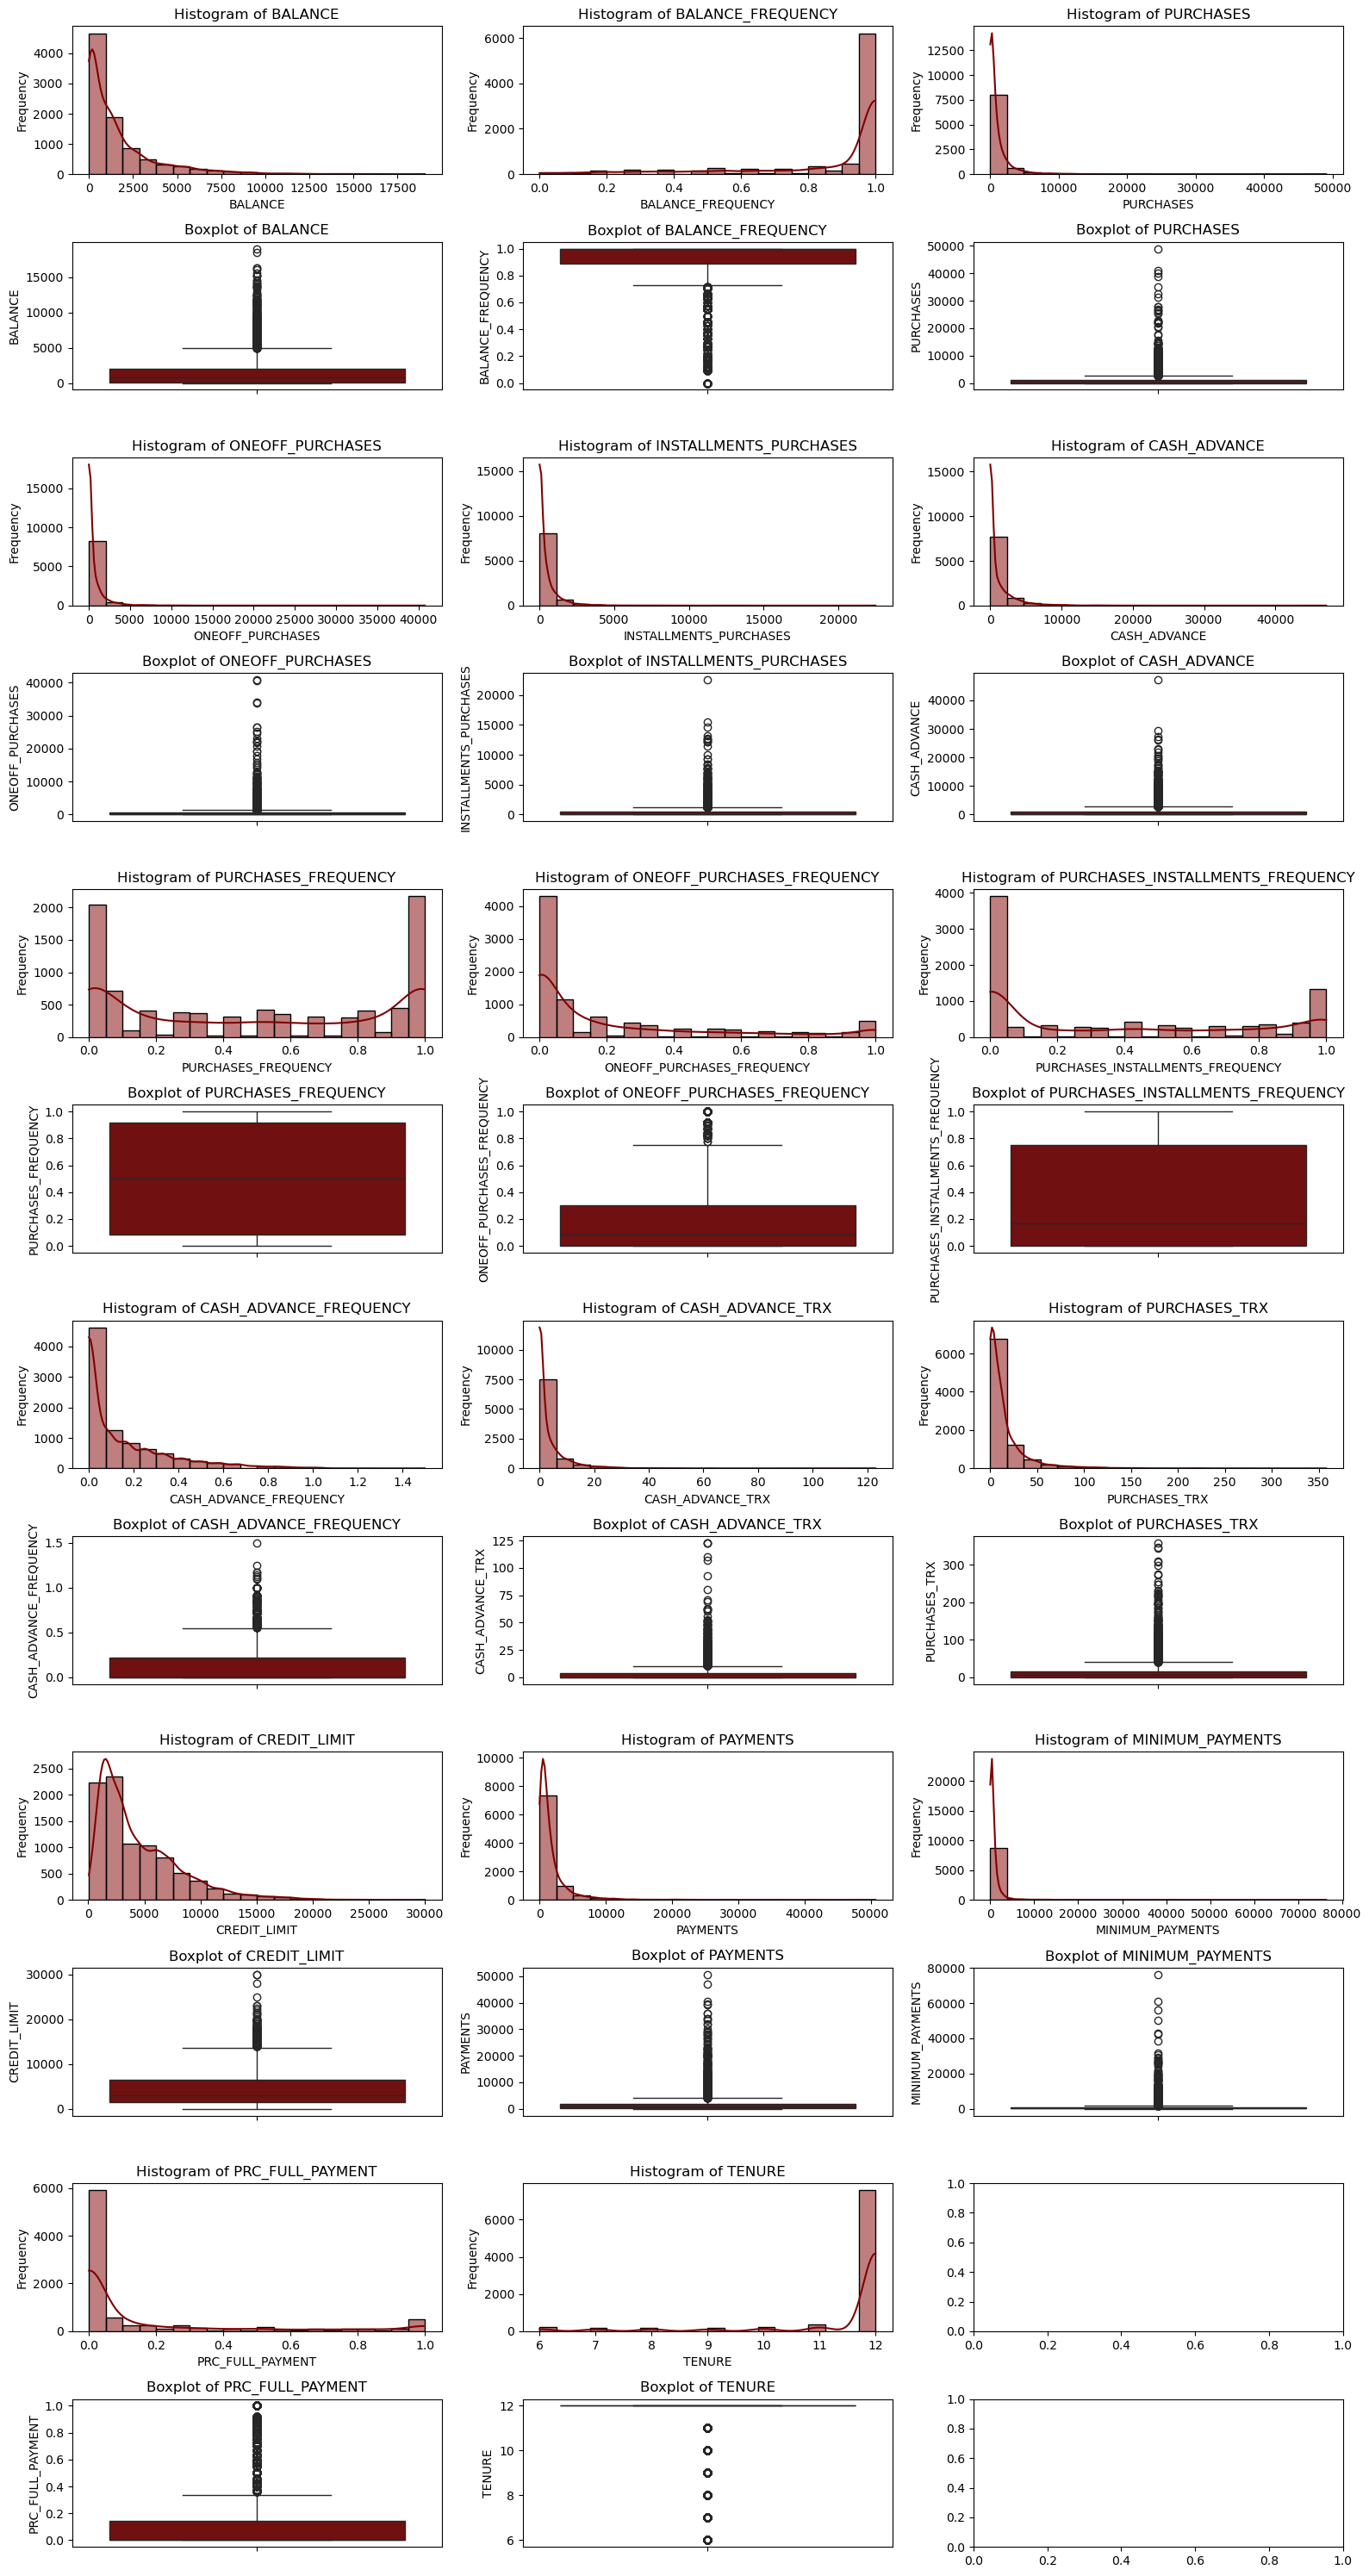

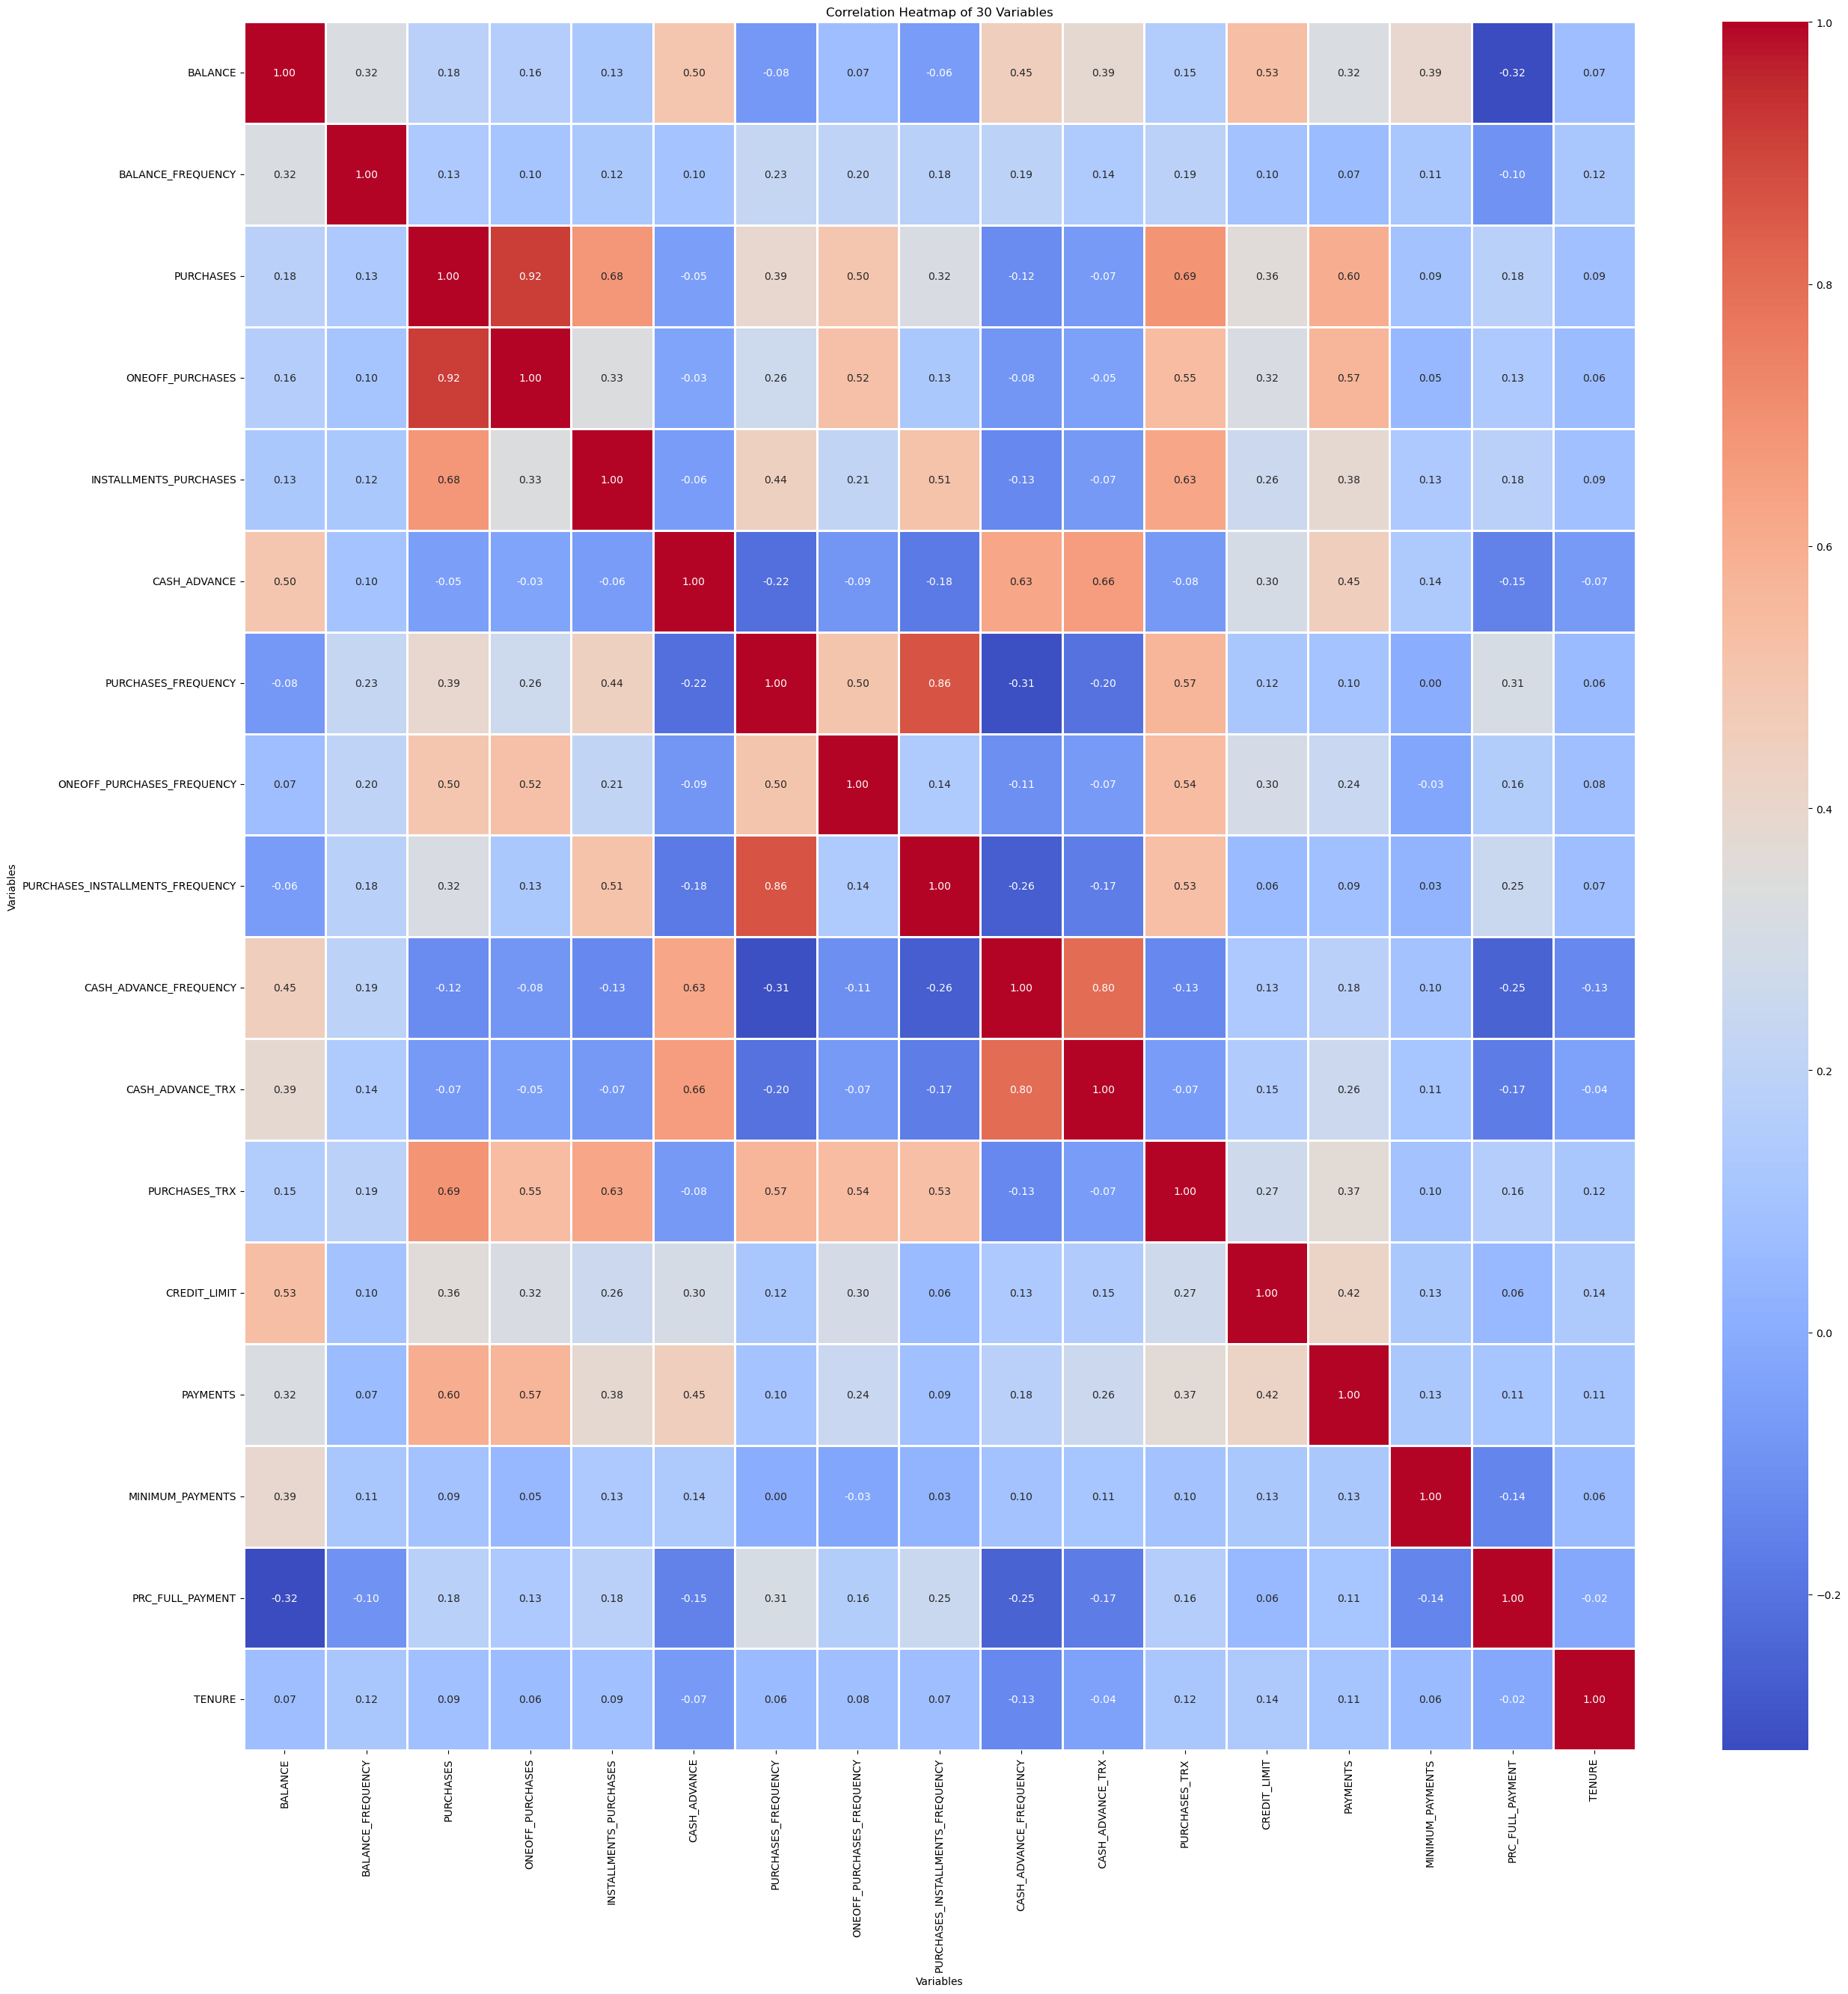

In [86]:
eda(data)

In [87]:
data.drop("CUST_ID",inplace=True,axis=1)

In [88]:
data.drop("PURCHASES",inplace=True,axis=1)

In [89]:
data.drop("INSTALLMENTS_PURCHASES",inplace=True,axis=1)

In [ ]:
#PCA and TSNSE clustering without any metrics

In [90]:
PCA2=data

In [91]:
TSNE2=data

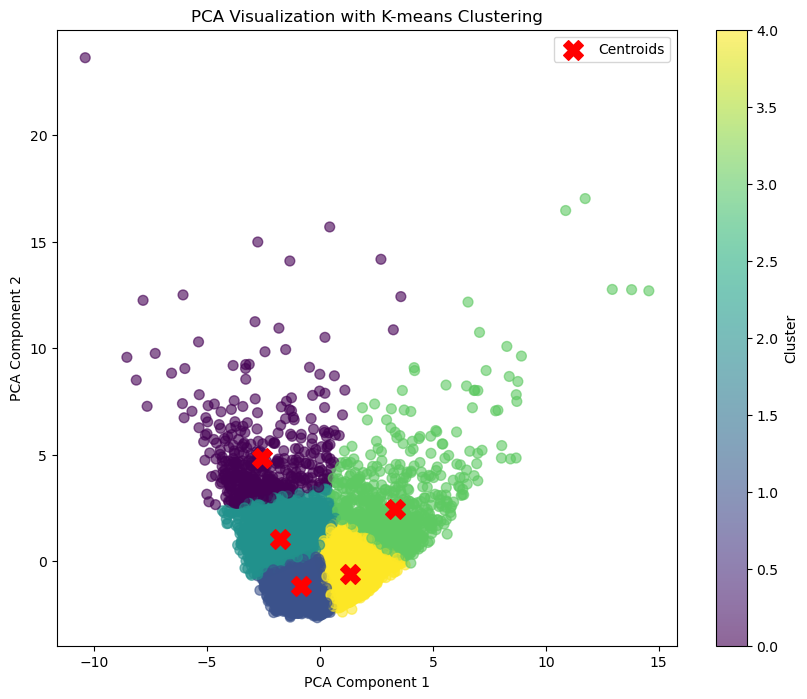

PCA Centroids:
 [[-2.56007626  4.83822615]
 [-0.85573918 -1.18328385]
 [-1.78148733  1.04134541]
 [ 3.32531665  2.42477068]
 [ 1.33880748 -0.58426408]]


In [95]:
pca_data, pca_labels, pca_centroids = PCA_Viz_with_KMeans(PCA2, n_clusters=5)


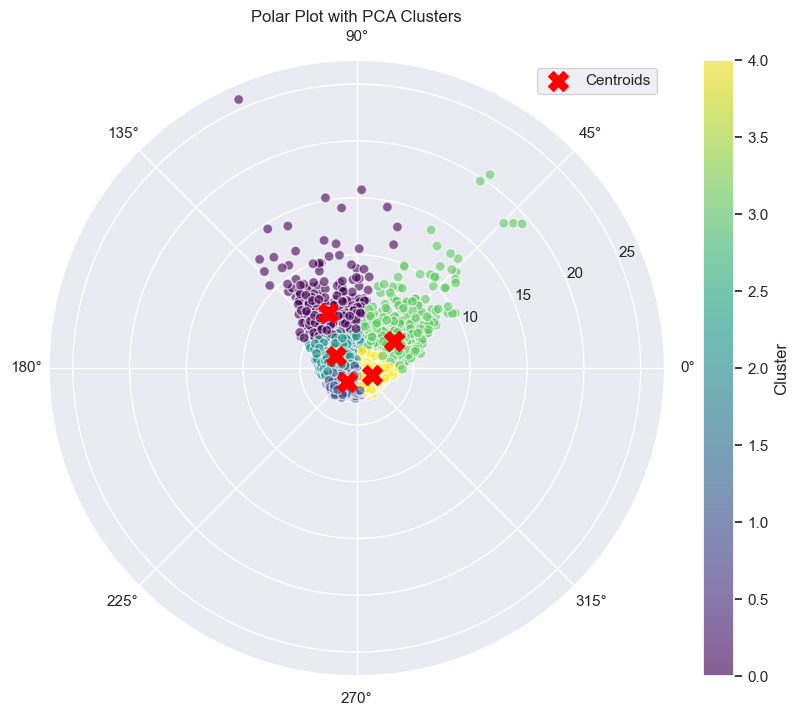

In [120]:
polar_plot(pca_data, labels, centroids, title='Polar Plot with PCA Clusters')

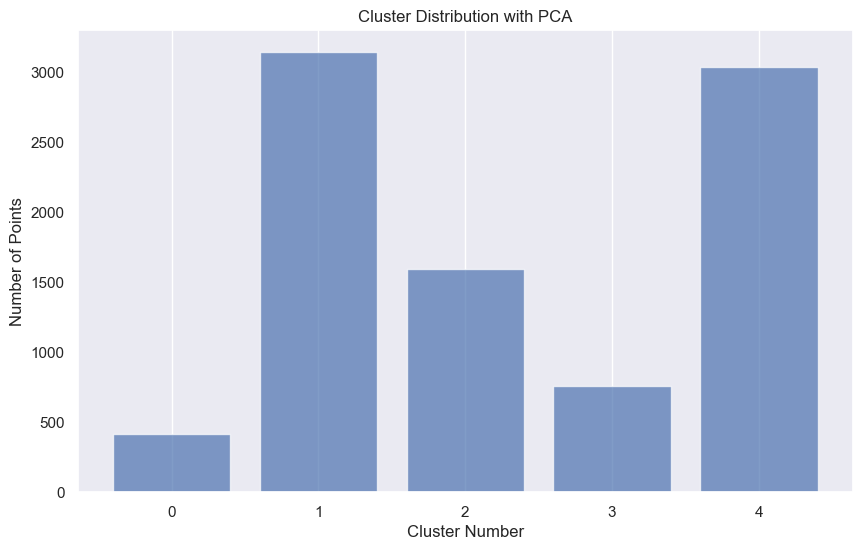

In [121]:
bar_plot_clusters(labels, title='Cluster Distribution with PCA')

In [ ]:
#Complete and clear separations are observed in the clusters with some outliers. As per the business knowledge we can interpreate that cluster 4 are the high value purchases users due to the centriod value.But as per the bar graph cluster 1 and 4 has the highest value and the highest purchases 

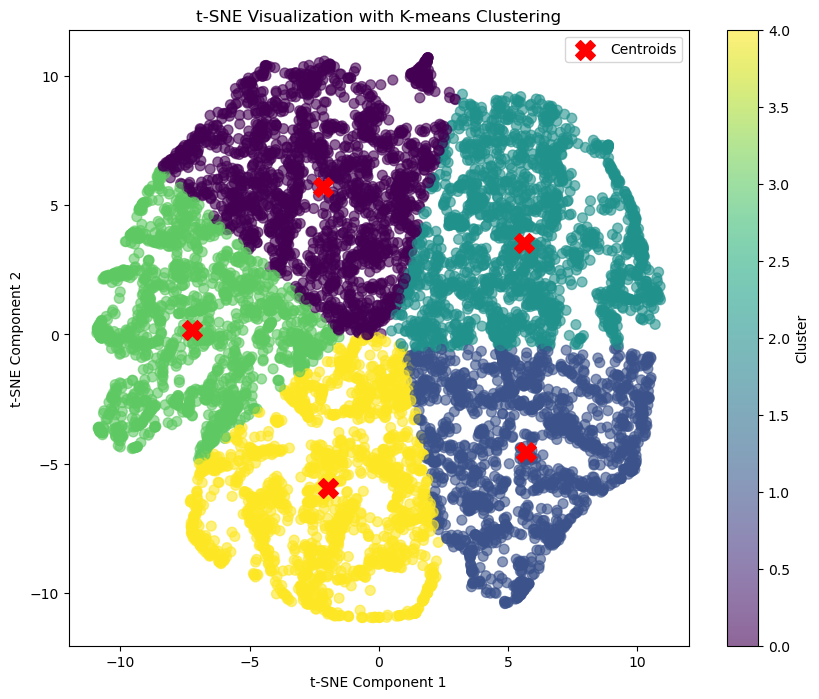

t-SNE Centroids:
 [[-2.1431427   5.708502  ]
 [ 5.6995316  -4.5367646 ]
 [ 5.6067147   3.5391788 ]
 [-7.2292576   0.16932133]
 [-1.9556723  -5.9419026 ]]


In [96]:
tsne_data, tsne_labels, tsne_centroids = tSNE_Viz_with_KMeans(TSNE2, n_clusters=5)

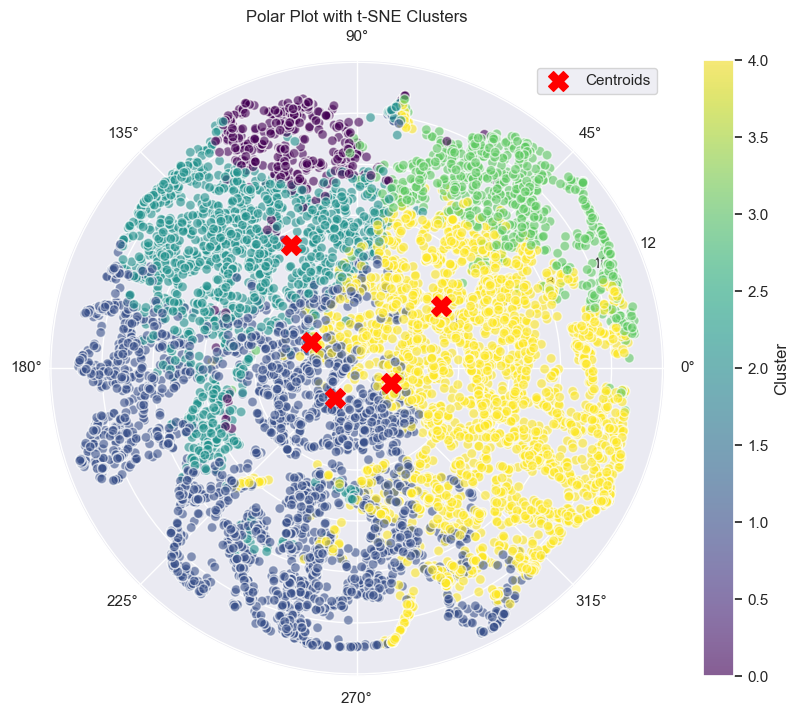

In [123]:
polar_plot(tsne_data, labels, centroids, title='Polar Plot with t-SNE Clusters')

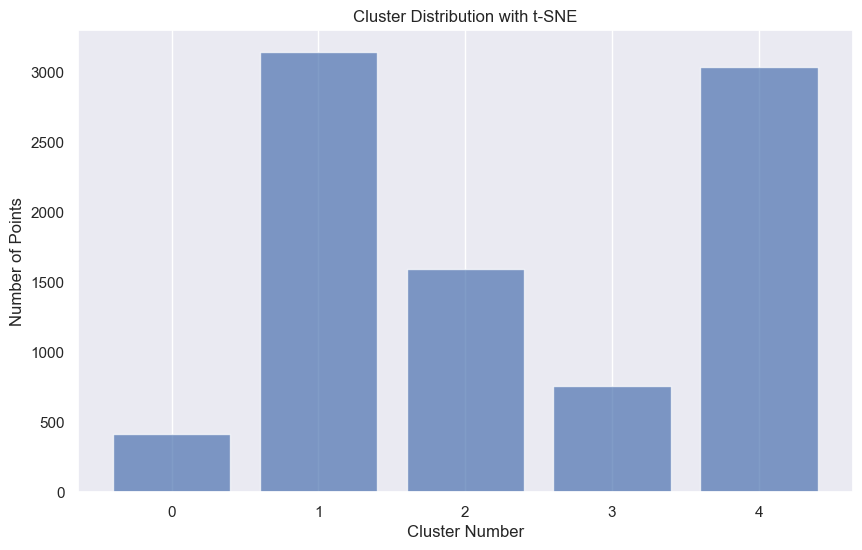

In [124]:
bar_plot_clusters(labels, title='Cluster Distribution with t-SNE')


In [ ]:
#Complete and clear separations are observed in the clustes in normal TSNE and bar graph however in polar graph improper clustering is observed. As per the business knowledge we can interpreate that cluster 4 are the high value purchases users due to the centriod value.But as per the bar graph cluster 1 and 4 has the highest value and the highest purchases 

In [ ]:
#Calculating Optimum number of clusters through Elbow method

In [98]:
# finding wcss value for different number of clusters
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    
print(wcss)

[344888204732.8399, 235557825650.6133, 209126746538.05402, 170453826749.8141, 147657418586.01245, 133594268692.28859, 123045239045.41333, 113084868268.78728, 103713980750.05887, 99169882476.16183]


Text(0.5, 1.0, 'The Elbow Point Graph')

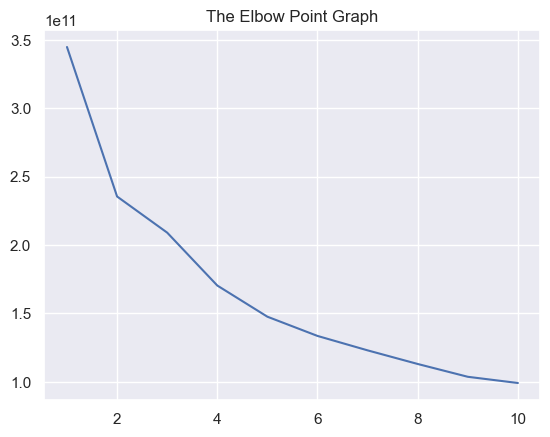

In [99]:
# Plot an elbow graph

sns.set()
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Point Graph')

In [ ]:
#From above interpretations lets now perform cluster analysis with the value of 2

In [100]:
PCA3=data

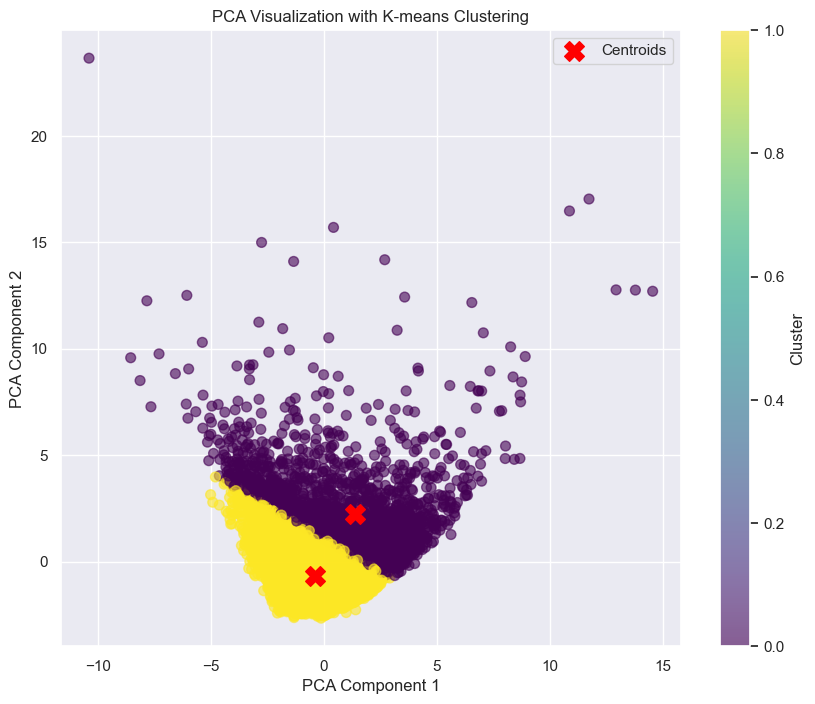

PCA Centroids:
 [[ 1.36086142  2.21147432]
 [-0.40559394 -0.65911236]]


In [134]:
pca_data, labels, centroids = PCA_Viz_with_KMeans(PCA3, n_clusters=2)

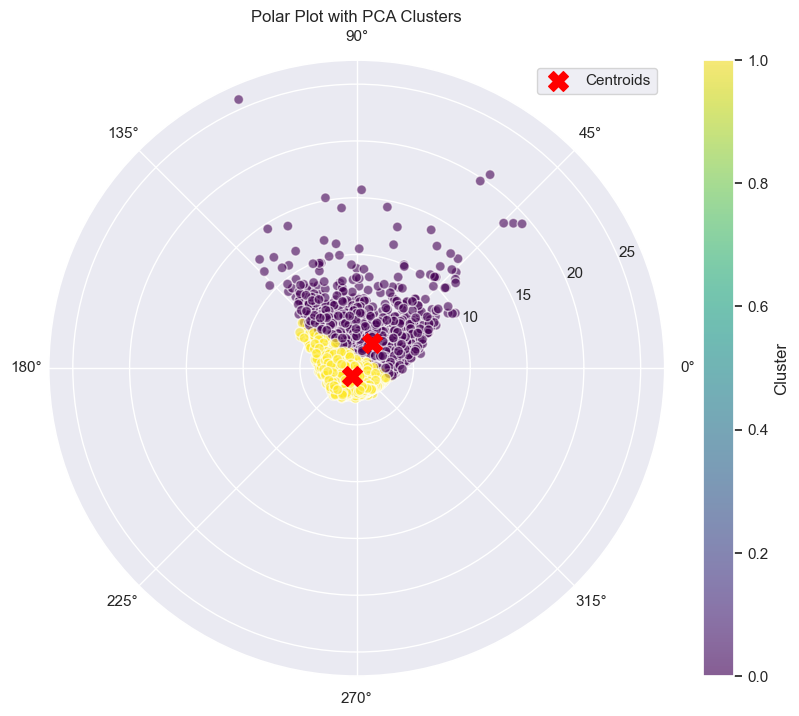

In [135]:
polar_plot(pca_data, labels, centroids, title='Polar Plot with PCA Clusters')

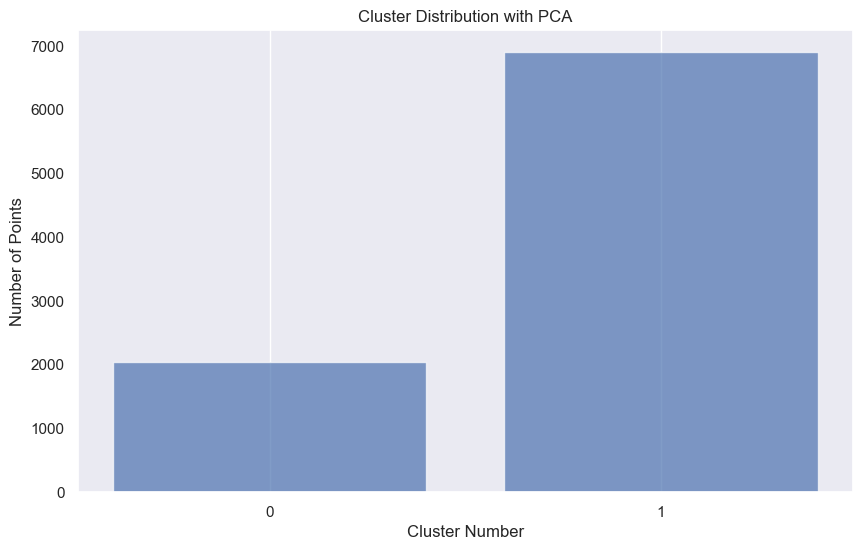

In [136]:
bar_plot_clusters(labels, title='Cluster Distribution with PCA')

In [ ]:
#Proper Segragation is observed. As per the business knowledge cluster no 1 has the highest value of number of purchases as compared to the cluster no 0

In [137]:
TSNE3=data

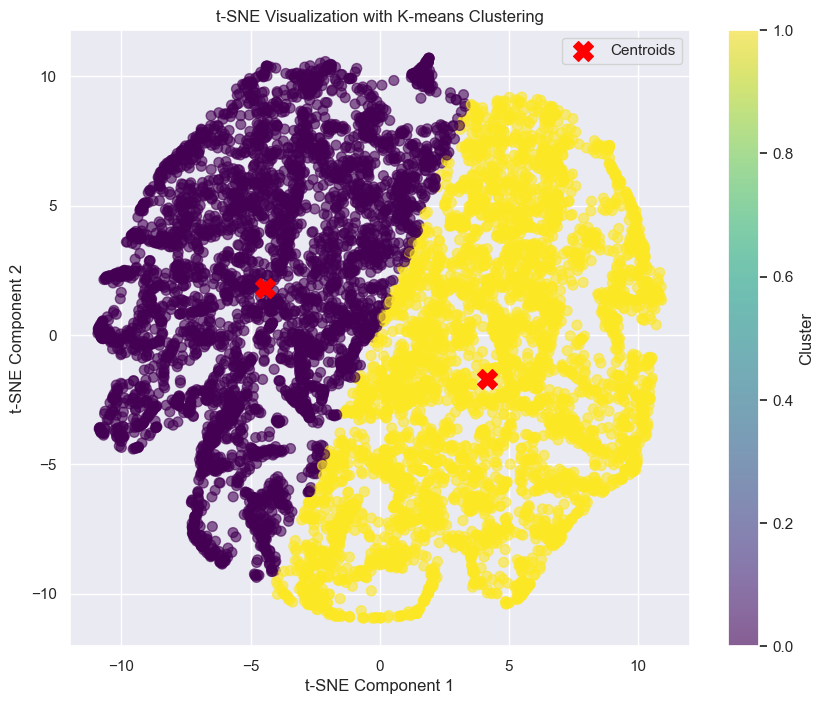

t-SNE Centroids:
 [[-4.452913   1.8305309]
 [ 4.138591  -1.694045 ]]


In [138]:
tsne_data, labels, centroids = tSNE_Viz_with_KMeans(TSNE3, n_clusters=2)

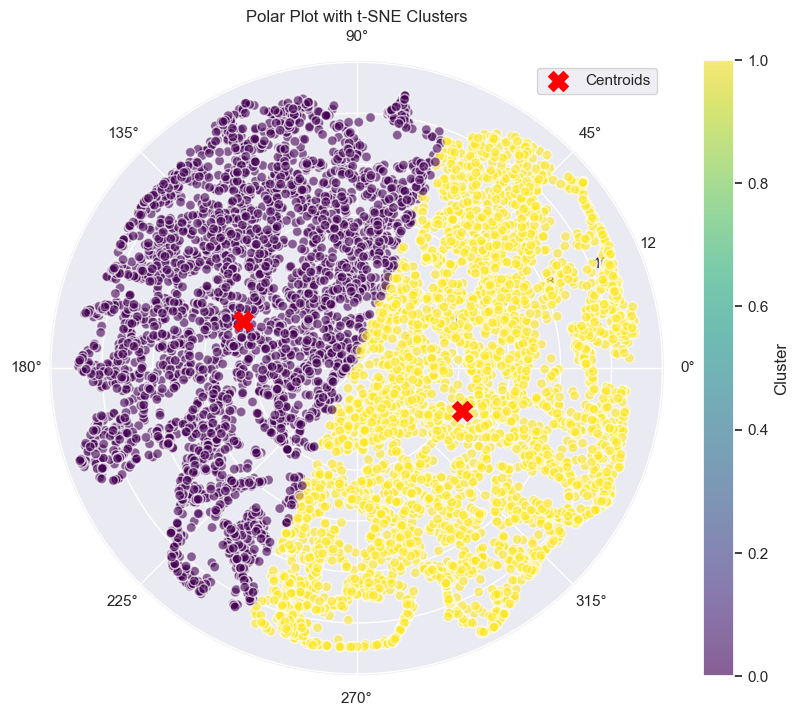

In [139]:
polar_plot(tsne_data, labels, centroids, title='Polar Plot with t-SNE Clusters')


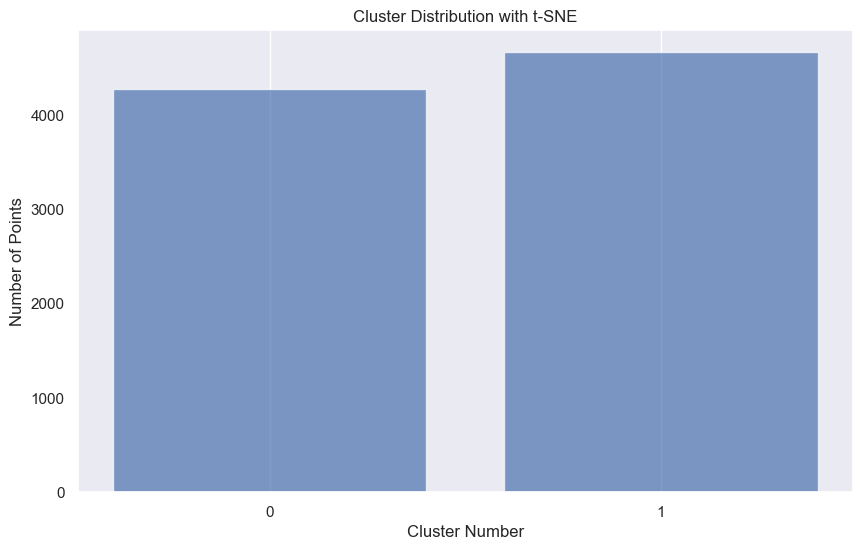

In [140]:
bar_plot_clusters(labels, title='Cluster Distribution with t-SNE')

In [ ]:
#Proper Segragation is observed. As per the business knowledge cluster no 1 has the highest value of number of purchases as compared to the cluster no 0

Cluster Numbers: [2, 3, 4, 5]
Silhouette Scores: [0.19970879820757348, 0.23079458584485424, 0.18951486379216384, 0.1948885225000176]


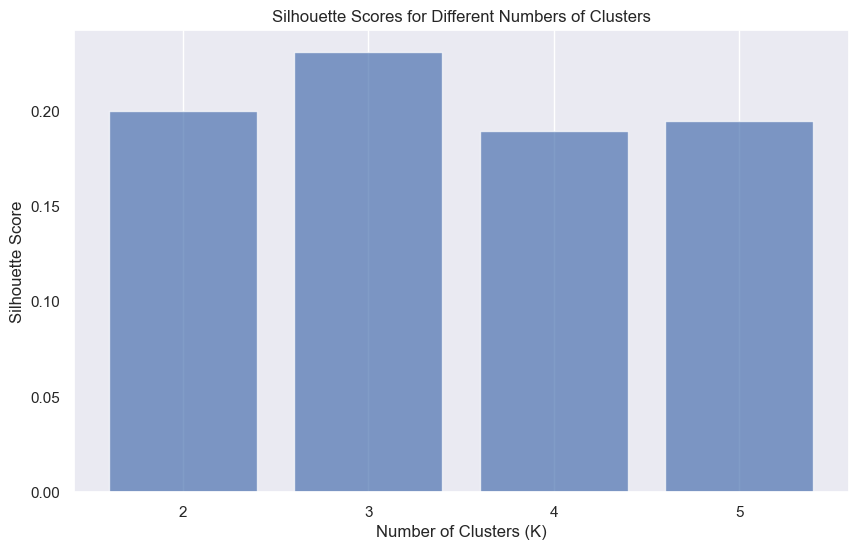

In [112]:
calculate_silhouette_scores(data, [2, 3, 4, 5])

In [ ]:
#As per the above interpretation highest segregation is observed in in the 3 number of clusters. 